# Near earth objects

#### https://cneos.jpl.nasa.gov/ca/

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta

In [2]:
now = datetime.now()
now = now.strftime("%Y-%m-%d")
now

'2021-12-29'

### Filter

In [3]:
# Entfernung in Lunar Distances (float)
filter_entfernung = 1

### data import, cleaning

In [4]:
df = pd.read_csv("D:\\Github\\Science\\NEO\\cneos_closeapproach_data.csv", sep=",")
df = df.drop(columns=['CA Distance Minimum (LD | au)', 'V relative (km/s)', 'V infinity (km/s)', 'H (mag)', 'Unnamed: 8'])

In [5]:
df["LD"] = df["CA Distance Nominal (LD | au)"].str.split(' ', expand = True)[0]
df["LD"] = pd.to_numeric(df["LD"], errors='coerce')

### Datum

In [6]:
df["Datum"] = df["Close-Approach (CA) Date"].str[:11]
df["Datum"] = pd.to_datetime(df["Datum"], errors='coerce', utc=True)
df = df.sort_values(by='Datum', ascending=True)

### calculation

In [7]:
df["distance_km"] = df["LD"]*394_399
df["zero"]=0
df["earth"] = 6_371
df["ISS"] = 6_371+408
df["geostationary"] = 35_786

### size

In [8]:
# km oder m auslesen
df["size_unit"] = df["Diameter"].str[-2:]

# Teile alle Durchmesser mit ±
df["d1"] = df["Diameter"].str.split('±', expand = True)[0]
df["d1"] = pd.to_numeric(df["d1"], errors='coerce')

# definiere size factor = 1000, ausser bei " m" = 1
df["size_factor"] = 1_000
df.loc[df["size_unit"] == " m", "size_factor"] = 1
df.head(3)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter,LD,Datum,distance_km,zero,earth,ISS,geostationary,size_unit,d1,size_factor
5805,(2021 YL),2021-Dec-28 11:22 ± 00:41,12.86 | 0.03304,21 m - 48 m,12.86,2021-12-28 00:00:00+00:00,5071971.14,0,6371,6779,35786,m,NaN,1
3316,(2017 AE3),2021-Dec-29 01:54 ± 6_06:03,9.22 | 0.02370,120 m - 260 m,9.22,2021-12-29 00:00:00+00:00,3636358.78,0,6371,6779,35786,m,NaN,1
19,(2021 YK),2022-Jan-02 17:14 ± 07:46,0.50 | 0.00128,8.9 m - 20 m,0.50,2022-01-02 00:00:00+00:00,197199.50,0,6371,6779,35786,m,NaN,1


In [9]:
# mittlerer Durchmesser ermitteln

df["d_von"] = df["Diameter"].str.split(' ', expand = True)[0]
df["d_von"] = pd.to_numeric(df["d_von"], errors='coerce')

df["d_bis"] = df["Diameter"].str.split('- ', expand = True)[1]
df["d_bis"] = df["d_bis"].str.split(' m', expand = True)[0]
df["d_bis"] = pd.to_numeric(df["d_bis"], errors='coerce')

df["mittel1"] = df["d1"] * df["size_factor"]
df["mittel1"] = df["mittel1"].fillna(1)

df["mittel2"] = (df["d_von"]+df["d_bis"]) *(1/2) * df["size_factor"]
df["mittel2"] = df["mittel2"].fillna(1)

df["diameter_mean"] = df["mittel1"] * df["mittel2"]

df = df.drop(columns=['d1', 
                      'd_von', 
                      'd_bis', 
                      'mittel1', 
                      'mittel2', 
                      'size_factor', 
                      'CA Distance Nominal (LD | au)', 
                      'size_unit',
                      'Close-Approach (CA) Date'])

# df

In [10]:
df = df.loc[df["LD"] < filter_entfernung]

In [11]:
max_größe = df["diameter_mean"].max()
df["marker_size"] = 300 * (df["diameter_mean"] / max_größe)
max_größe

932.0

### Position Textboxen

In [12]:
df = df.sort_values(by='Datum', ascending=True)
df.index = np.arange(1, len(df) + 1 )
df["x_axis"] = df.index

x_achse_max = df["x_axis"].max()
print(x_achse_max)
df["pos_x_achse"] = (df["x_axis"] / x_achse_max)*0.90

65


In [13]:
df = df.sort_values(by='distance_km', ascending=True)
y_achse_max = df["distance_km"].max()
print(y_achse_max)
df["pos_y_achse"] = (df["distance_km"] / y_achse_max)*0.97

390455.01


In [14]:
# definiere size factor = 1000, ausser bei " m" = 1
df = df.sort_values(by='diameter_mean', ascending=False)
df.index = np.arange(1, len(df) + 1 )
df["x_axis"] = df.index

df.loc[df["x_axis"] <=5 , "Top5"] = df["Object"]
df["Top5"] = df["Top5"].fillna("")
df = df.sort_values(by='diameter_mean', ascending=True)

In [15]:
df = df.sort_values(by='Datum', ascending=True)

### visualize

<Figure size 432x288 with 0 Axes>

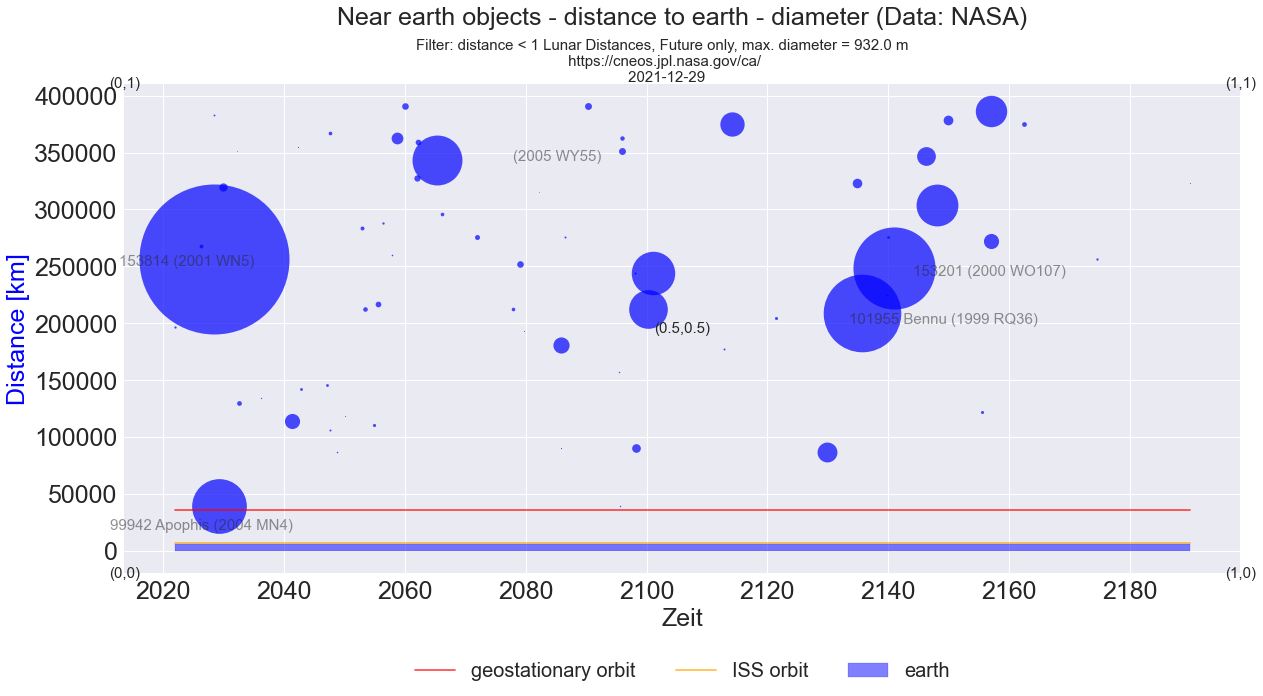

In [16]:
plt.clf()

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(20, 9))
# plt.plot(df["distance_km"],color="blue", alpha=0.7, marker=".", markersize=marker_size_list1,
#          linestyle="", label="Near earth object")


[ax.plot(row['Datum'], row['distance_km'], '.', markersize=row['marker_size'], alpha=0.7, color = "blue", label = "") for idx, row in df.iterrows()]

[ax.text(row['pos_x_achse'], row['pos_y_achse'], row['Top5'], horizontalalignment='center', alpha=0.5, verticalalignment='center', transform=ax.transAxes, size=15) for idx, row in df.iterrows()]

# plt.plot(df["zero"],color="brown", alpha=0.7, marker="", markersize=10,
#          linestyle="-", label="")

# plt.plot(df["earth"],color="brown", alpha=0.7, marker="", markersize=10,
#          linestyle="-", label="")

plt.fill_between(df["Datum"], df['earth'], df['zero'], color='blue', alpha=0.5,
                 label=f'earth')

plt.plot(df["Datum"], df["geostationary"],color="red", alpha=0.7, marker="", markersize=10,
         linestyle="-", label="geostationary orbit")

plt.plot(df["Datum"], df["ISS"],color="orange", alpha=0.7, marker="", markersize=10,
         linestyle="-", label="ISS orbit")

ax.text(0, 0, "(0,0)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
ax.text(0, 1, "(0,1)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
ax.text(1, 0, "(1,0)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
ax.text(0.5, 0.5, "(0.5,0.5)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
ax.text(1, 1, "(1,1)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)

ax.set_xlabel("Zeit", fontsize=25)
ax.set_ylabel("Distance [km]", color="blue", fontsize=25)

ax.tick_params(labelsize=25)

plt.legend(loc='center',
           bbox_to_anchor=(0.5, -0.2),
           fancybox=True,
           shadow=True,
           ncol=4,
           fontsize=20)

plt.title(f' Near earth objects - distance to earth - diameter (Data: NASA) \n\n', fontsize=25)
plt.suptitle(f'Filter: distance < {filter_entfernung} Lunar Distances, Future only, max. diameter = {max_größe} m \n https://cneos.jpl.nasa.gov/ca/ \n {now}', fontsize=15, y=0.95)

plt.savefig(f'D:\\Github\\Science\\NEO\\NEO_{filter_entfernung} Lunar Distances.png', dpi=300, bbox_inches='tight')

